In [1]:
import openmc

In [2]:
### Begin Materials Section ###

uo2 = openmc.Material(1, "uo2")
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.temperature = 1000 #K
uo2.set_density('g/cm3', 10.0)
uo2.volume = 4.14072 #cm^3
uo2.depletable = True


zirconium = openmc.Material(2, "zirconium")
zirconium.add_element('Zr', 1.0, 'wo')
zirconium.set_density('g/cm3', 6.6)


water = openmc.Material(3, "h2o")
water.add_nuclide('H1', 2.0)
water.add_element('O', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')
water.set_density('g/cm3', 1.0)


mats = openmc.Materials([uo2, zirconium, water])
mats.export_to_xml()

### End Materials Section ###

In [3]:
### Begin Geometry Section ###

sph_1 = openmc.Sphere(r=1.0)
sph_2 = openmc.Sphere(r=1.1)

xz_plane = openmc.YPlane(y0=0)
yz_plane = openmc.XPlane(x0=0)


boundbox_xlow = openmc.XPlane(x0 = -2.0, boundary_type='vacuum')
boundbox_xhigh = openmc.XPlane(x0 = 2.0, boundary_type='vacuum')
boundbox_ylow = openmc.YPlane(y0 = -2.0, boundary_type='vacuum')
boundbox_yhigh = openmc.YPlane(y0 = 2.0, boundary_type='vacuum')
boundbox_zlow = openmc.ZPlane(z0 = -2.0, boundary_type='vacuum')
boundbox_zhigh = openmc.ZPlane(z0 = 2.0, boundary_type='vacuum')


NW_sphere = -sph_1 & +xz_plane & -yz_plane
inside_sphere = -sph_1 & (-xz_plane | +yz_plane) #OR -sph_1 & ~NW_sphere
shell = +sph_1 & -sph_2
boundbox = +boundbox_xlow & -boundbox_xhigh & +boundbox_ylow & -boundbox_yhigh & +boundbox_zlow & -boundbox_zhigh
outside_sphere = +sph_2 & boundbox


sphere_NW_cell = openmc.Cell(region=NW_sphere, fill=uo2)
sphere_in_cell = openmc.Cell(region=inside_sphere, fill=uo2)
shell_cell = openmc.Cell(region=shell, fill=zirconium)
sphere_out_cell = openmc.Cell(region=outside_sphere, fill=water)


universe = openmc.Universe(cells=[sphere_NW_cell, sphere_in_cell, shell_cell, sphere_out_cell])


geom = openmc.Geometry(universe)
geom.export_to_xml()

### End Geometry Section ###

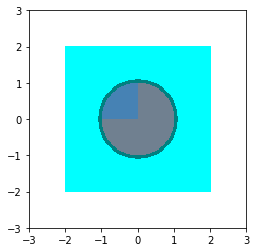

In [4]:
universe.plot(basis='xy', \
              origin=(0.0, 0.0, 0.0), \
              width=(6.0, 6.0), \
              pixels=(200,200), \
              colors = {sphere_NW_cell: 'steelblue', \
                       sphere_in_cell: 'slategrey', \
                       shell_cell: 'teal', \
                       sphere_out_cell: 'aqua'}) #SVG colornames

In [5]:
### Begin Settings Section ###

point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

settings = openmc.Settings()
settings.source = src
settings.batches = 120
settings.inactive = 20
settings.particles = 10000
settings.temperature = {'method': 'interpolation'}

settings.export_to_xml()

### End Settings Section ###

In [6]:
### Begin Tallies Section ###

shell_cell_filter = openmc.CellFilter(shell_cell)

shell_tally = openmc.Tally(1, name='Shell Tally')
shell_tally.filters = [shell_cell_filter]
shell_tally.scores = ['absorption']

tallies = openmc.Tallies([shell_tally])

#tallies.export_to_xml()

### End Tallies Section ###

In [7]:
### Begin Depletion Section ###

import openmc.deplete

chainpath = "/home/nickwolf10/openmc/Cross_Section_Libraries/endfb71_hdf5/chain_endfb71_sfr.xml" #example path
chain = openmc.deplete.Chain.from_xml(chainpath)

operator = openmc.deplete.Operator(geom, settings, chainpath)

power = 100e3 #W; power rating for the reactor

max_step = 2 * operator.heavy_metal / power * 1e3 #days; haevy_metal is mass of fuel atom in kg
time_steps = 4*[max_step * 24 * 60 * 60] #days -> s

integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power)

integrator.integrate()

### End Depletion Section ###

In [8]:
### Begin Outputs Section ###

print('\n' + "- - - - - - - - - - - - - - - - - - - - - - -" + '\n')
print("Depletion Results:")
print('\t' + "Each Timestep is " + str(round(max_step,3)) + " days.")
print('\t' + "Initial mass of Heavy Metal: " + str(operator.heavy_metal) + " g")

import numpy as np
import h5py

deplete_results = h5py.File('./depletion_results.h5', 'r')

time = np.array(deplete_results.get('time'))
time /= (30 * 24 * 60 * 60) # convert from seconds to months

deplete_k = np.array(deplete_results.get('eigenvalues'))

deplete_results.close()

#report k-values w/ errorbars
print('\n\t' + "Depletion k_eff results:")
print(str(deplete_k))

### End Outputs Section ###


- - - - - - - - - - - - - - - - - - - - - - -

Depletion Results:
	Each Timestep is 0.73 days.
	Initial mass of Heavy Metal: 36.50033856955367 g

	Depletion k_eff results:
[[[1.64790532e-02 2.86573175e-05]]

 [[1.62946476e-02 3.24329119e-05]]

 [[1.62619449e-02 2.31737677e-05]]

 [[1.61984557e-02 2.61338069e-05]]

 [[1.61571804e-02 2.35111632e-05]]]


In [9]:
### Begin DepletionParse Section ###

import numpy as np
import h5py
import matplotlib.pyplot as plt
import openmc.deplete
%matplotlib inline

dep_file = './depletion_results.h5'
deplete_results = h5py.File(dep_file, 'r')

print(deplete_results.keys())

time = np.array(deplete_results.get('time'))
time /= (30 * 24 * 60 * 60) # convert from seconds to months
deplete_k = np.array(deplete_results.get('eigenvalues'))

deplete_results.close()

<KeysViewHDF5 ['depletion time', 'eigenvalues', 'materials', 'nuclides', 'number', 'power', 'reaction rates', 'reactions', 'time']>


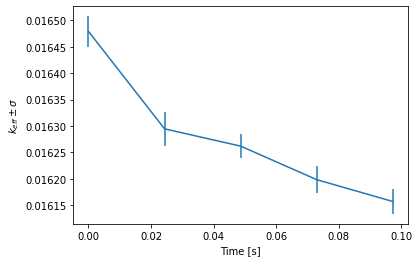

In [10]:
#plot k-values w/ errorbars
plt.errorbar(time[:, 0], deplete_k[:, 0, 0], yerr=deplete_k[:, 0, 1])
plt.xlabel("Time [s]")
plt.ylabel("$k_{eff}\pm \sigma$");

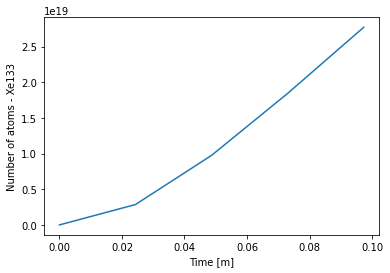

In [15]:
#plot atom concentrations in each material
results = openmc.deplete.ResultsList.from_hdf5(dep_file)


time, activated = results.get_atoms('1', "Xe133")
time /= (30 * 24 * 60 * 60) # convert from seconds to months

plt.plot(time, activated, label="Xe133")
plt.xlabel("Time [m]")
plt.ylabel("Number of atoms - Xe133");

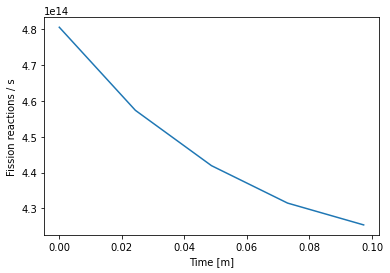

In [16]:
#plot reaction rates over time
_time, u3_fission = results.get_reaction_rate('1', "U235", "fission")


plt.plot(time, u3_fission)
plt.xlabel("Time [m]")
plt.ylabel("Fission reactions / s");

### End DepletionParse Section ###